In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None 

# 1. Dataset Exploration
## 1.1 How does the dataset looks like ? 

In [2]:
youtube_df = pd.read_feather("../data/youtube_big.feather")
youtube_df.head()

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,categories_raw,top5p_cat,top1p_cat,is_invalid,top5p,top1p
0,Music,UCsv6iJMuTZc8-zs3V2Z9B6w,0,uKGGM22X8Qs,429,4,2019-09-12,194,Music,False,False,False,False,False
1,Music,UCsv6iJMuTZc8-zs3V2Z9B6w,11,jzBaT9_h0aw,377,44,2019-06-20,2668,Music,False,False,False,False,False
2,Music,UCsv6iJMuTZc8-zs3V2Z9B6w,6,giozLk4q51A,295,66,2019-05-02,4350,Music,False,False,False,False,False
3,Music,UCsv6iJMuTZc8-zs3V2Z9B6w,0,df4qDGsSDdg,338,5,2018-03-04,138,Music,False,False,False,False,False
4,Music,UCsv6iJMuTZc8-zs3V2Z9B6w,0,MNW-OvHFibs,334,9,2018-03-04,329,Music,False,False,False,False,False


In [3]:
youtube_df.isnull().sum()

categories        0
channel_id        0
dislike_count     0
display_id        0
duration          0
like_count        0
upload_date       0
view_count        0
categories_raw    0
top5p_cat         0
top1p_cat         0
is_invalid        0
top5p             0
top1p             0
dtype: int64

In [4]:
len(youtube_df)

69901917

**So we have about 70mio of lines with no null values**

## 1.2 What are the categories ? 

In [5]:
categoriesCount = youtube_df[['categories','channel_id']].groupby('categories').count()
categoriesCount.columns = ['nb_of_video_per_categories']
categoriesCount.sort_values(by=['nb_of_video_per_categories'],ascending=False)

,nb_of_video_per_categories
categories,
Entertainment,19870371
Gaming,12681265
Others,10588948
News & Politics,9024146
Music,8231523
"Education, Science & Tech",5886668
Howto & Style,3618007
,989


We have 7 different named categories. There appears to be 989 rows that have no associated categories

## 1.3 What are categories_raw ? 

In [6]:
categoriesRawCount = youtube_df[['categories_raw','channel_id']].groupby('categories_raw').count()
categoriesRawCount.columns = ['count']
categoriesRawCount

,count
categories_raw,
,989
"Education, Science & Tech",5886668
Entertainment,19870371
Gaming,12681265
Howto & Style,3618007
Music,8231523
News & Politics,9024146
Others,10588948


Seems to be exactly the same than the column "categories"...

## 1.4 Are the display_id really unique ? 

In [7]:
 youtube_df[['display_id']][youtube_df[['display_id']].duplicated()]

,display_id
250,XOmPr1feFHU
251,1bgkJ52aU5w
585,bf58l61iUSs
622,29pOl5Y5Ycc
754,ES_HdxP3hio
...,...
69899184,8t6GeEhIr-Q
69899407,IueeqJIkYm8
69899493,OVRkhBzmDq0
69901104,ZDY9uXuOufU


Sadly no we have originally some duplicates! See example below...

In [8]:
youtube_df[youtube_df['display_id'] == 'XOmPr1feFHU']


,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,categories_raw,top5p_cat,top1p_cat,is_invalid,top5p,top1p
247,Howto & Style,UCsv5Rytct54UTBdSKw2Nh4Q,13,XOmPr1feFHU,262,232,2012-12-22,23484,Howto & Style,False,False,False,False,False
250,Howto & Style,UCsv5Rytct54UTBdSKw2Nh4Q,13,XOmPr1feFHU,262,232,2012-12-22,23484,Howto & Style,False,False,False,False,False


## 1.5 Upload Date:

In [17]:
print("Info available from {} to {} ".format(*youtube_df.upload_date.agg({'min', 'max'})))

Info available from 2005-07-14 00:00:00 to 2019-11-20 00:00:00 


## 1.6 How many different channels ? 

In [10]:
nbOfChannels = len(youtube_df['channel_id'].unique())
print("There are {} different channels distributed that way (Some channel may post videos over multiple categories): ".format(nbOfChannels))


channelPerCatDF = youtube_df[['categories','channel_id']].drop_duplicates().groupby('categories').count()
channelPerCatDF.columns = ["nb_of_different_channels"]
channelPerCatDF.sort_values(by=['nb_of_different_channels'],ascending=False)


There are 144438 different channels distributed that way (Some channel may post videos over multiple categories): 


,nb_of_different_channels
categories,
Entertainment,96976
Others,56171
Music,55780
"Education, Science & Tech",32069
Gaming,31320
Howto & Style,28805
News & Politics,11201
,357


## 1.7 Is_invalid distribution
is_invalid is true if the video isn't actually in english. In this dataframe, they shall already have been filtered out

In [11]:
youtube_df.is_invalid.value_counts()

False    69901917
Name: is_invalid, dtype: int64

## 1.8 Recap

Recap: 
* a few videos don't have an assigned categories. As it represents roughly 0.01% we can ignore them. 
* display_id not necessary unique => need to remove duplicates
* categories and categories_raw seems to be identical => drop a column
* is_invalid: could drop this column too as this dataframe contains only english videos.

Note on other columns, those are computed value (and could be recomputed if necessary):
* topxp: This video is in the top x% global (in raw view count) over a 6-month period (Jan-June, Jul-Dec).
* topxp_cat: Same idea but grouped by categories (as the number of videos and views per categorie aren't distributed uniformly)

**Note:** We can imagine recomputing such statistics to a finer grain level depending on the visualizaiton needs

# 2. Some plots of the distributions

In [12]:
year_df = youtube_df.groupby(youtube_df.upload_date.dt.year).display_id.count()

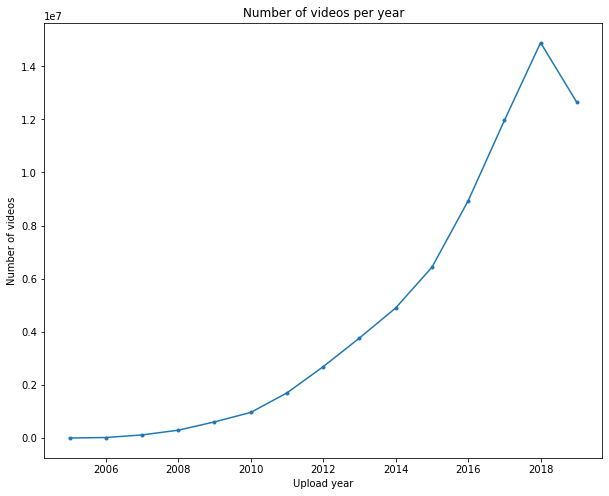

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
year_df.plot(ax=ax, style='.-')
ax.set_title('Number of videos per year')
ax.set_xlabel('Upload year')
ax.set_ylabel('Number of videos')
plt.show()

Note that the collection stopped in november 19, so we miss ~10% of the data for 2019

In [14]:
cat_df = youtube_df[youtube_df.categories != ''].groupby('categories').display_id.count()

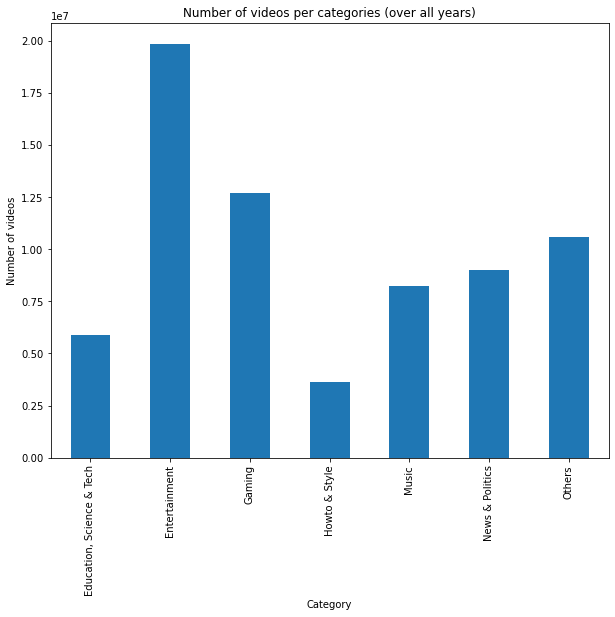

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
cat_df.plot(ax=ax, kind='bar')
ax.set_title('Number of videos per categories (over all years)')
ax.set_xlabel('Category')
ax.set_ylabel('Number of videos')
plt.show()

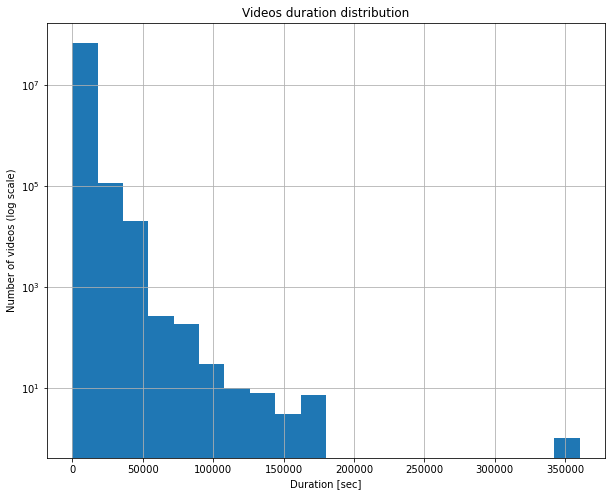

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
youtube_df.duration.hist(bins=20, log=True)
ax.set_title('Videos duration distribution')
ax.set_xlabel('Duration [sec]')
ax.set_ylabel('Number of videos (log scale)')
plt.show()

# 3. What can we do with this data? 

Along what is currently proposed in the original research (see 1.4 Related Work in the readme), we also propose our own approach to enrich the work and, as a reminder, aim at understanding **How the content evoloved on YouTube this last 15 years?**:
* What are the kinds of content and formats that prospered on YouTube through the years?
* How have content creation practices changed through years on YouTube? What are the most revealing channels / videos of those trends?

We propose here a rough (early) draft of some visualizations we may want to use to answer these questions (This will be formalized by Milestone 2)

<img src="../resources/img/image_ideas.jpg">

### 1) Popular categories over time

We would like to present a such graph which represents a ratio for our 7 categories (Entertainment, Gaming, Others, News & Politics, Music, Education, Science & Tech, Howto & Style) and those that have been the most important over time. 

To calculate the most important categories, it will be a function of the number of like/dislike videos, the number of views, the date and the category. (for example, we could count +1 for a video seen, -1 for a video seen and not liked and +2 for a video seen and liked. Additional research of litterature and consultation with the PhD student will also be approached, as well as the idea of a weighting scheme as the all videos / channel on YouTube are not created equal).

We propose that the visual dynamical interaction is such that dragging the mouse over the graph make appears at the bottom the information **(2.a)**, and that clicking on the graph will make appear the information **(3)**. The user could also be able to select a time frame to analyze (typically move a cursor below the graph)

### 2.a) An overview of the top videos
Using the same formula we used to rank the categories over time, we select the 5 most important videos at that time over all categories (the videos that have the highest score) and we display them. There should be a line for each video with the some data (category, channel, bar showing nb of like/dislike) duration, picture, link to youtube,...).

### 3) The subgraph for a particular category of media
Since clicking on the **(1)** graph on a particular category make appears this graph, it should display only informations about the particular selected category. 
This graph has as title the category selected, and below it a clickable segment (**(4)**) that will display different kind of information for this category. We can imagine to have: 
* A duration button: clicking on it will make appear a simple graph that show the average duration of the videos over time for this category.
* A ranking button: will display a bar graph that shows, according to the formula used to compute **(1)**, the ranking of this category overtime. (I propose that going on hover this graph will show the ranking of all categories at that time.)
* A view button that will show a graph (same kind that **(1)** ) that display the number of like, dislike, and average view for this category over time. Clicking on the green part will hilight it, same for the red or gray part. Depending on the selected part of the graph, we will display **(2.c), (2.d) or 2.e)**
* A Most popular channel button: can display the most popular channel over time for this category.
* ...

### 2.b)
Exactly the same that **(2.a)** but display only the videos for this category. 

### 2.c), 2.d), 2.e)
With the same interface type that **(2.a) and (2.b)**, theses subwindows will respectively display: 
* (2.c) The most liked videos for a particular category over time
* (2.d)The most hated videos for a particular category over time
* (2.e)The most viewed videos for a particular category over time